In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm

In [2]:
path = r"C:\Users\ALI\Desktop\hamsi\hamsi.xlsx"
df = pd.read_excel(path)

data = df.iloc[:, 2:-3].dropna()
data.columns

Index(['Temp (C)', 'Baro (mb)', 'Depth (m)', 'pH', 'pHmV', 'ORP (REDOX)',
       'DO (% Sat)', 'DO (mg/L)', 'EC (uS/cm @25C)', 'RES (Ohms.cm)',
       'TDS (mg/L)', 'SAL (PSU)', 'Turbidity (NTU)', 'CDOM (ug/L)',
       'Chlorophyll (ug/L)'],
      dtype='object')

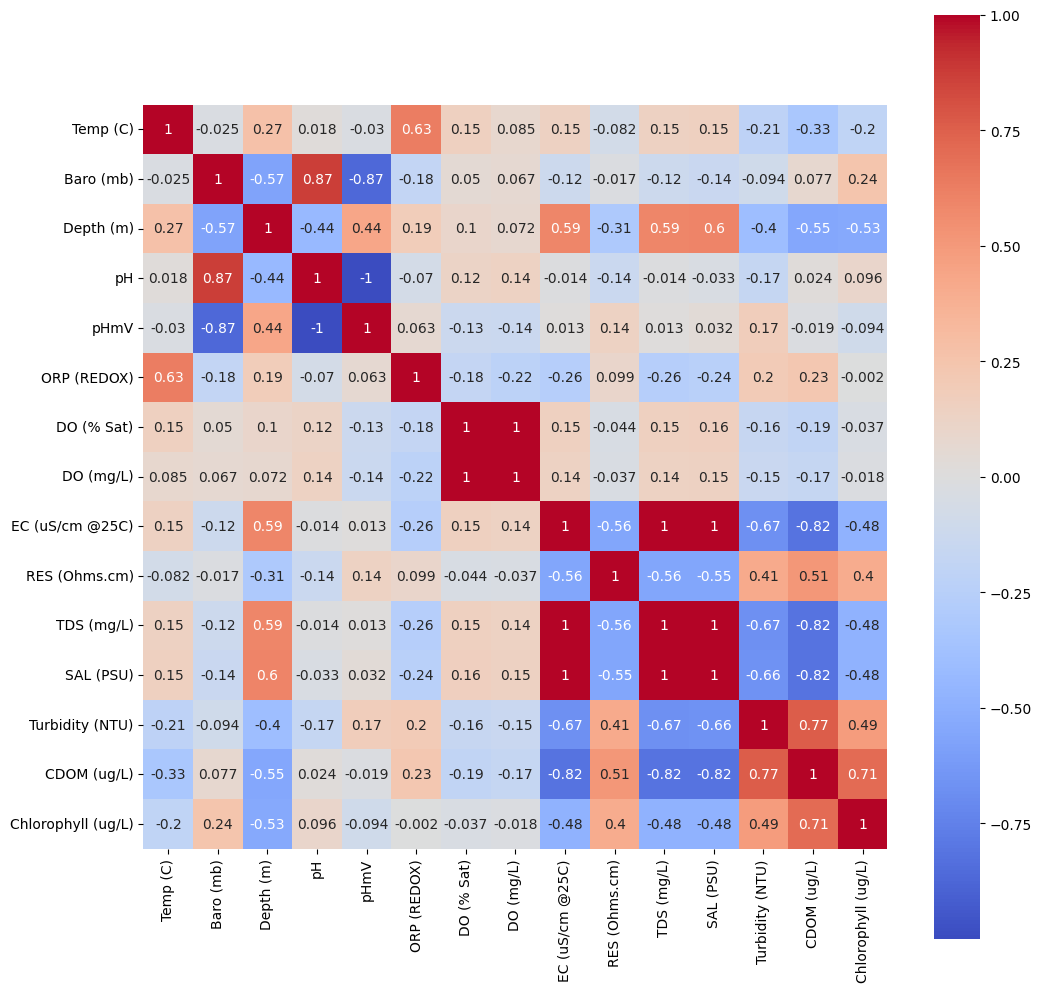

In [3]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

In [4]:
remove_columns = ["pHmV", 'EC (uS/cm @25C)', 'TDS (mg/L)']
data = data.drop(columns=remove_columns)
data.columns

Index(['Temp (C)', 'Baro (mb)', 'Depth (m)', 'pH', 'ORP (REDOX)', 'DO (% Sat)',
       'DO (mg/L)', 'RES (Ohms.cm)', 'SAL (PSU)', 'Turbidity (NTU)',
       'CDOM (ug/L)', 'Chlorophyll (ug/L)'],
      dtype='object')

In [5]:
data_norm = MinMaxScaler().fit_transform(data)

In [6]:
D = len(data.columns)
D

12

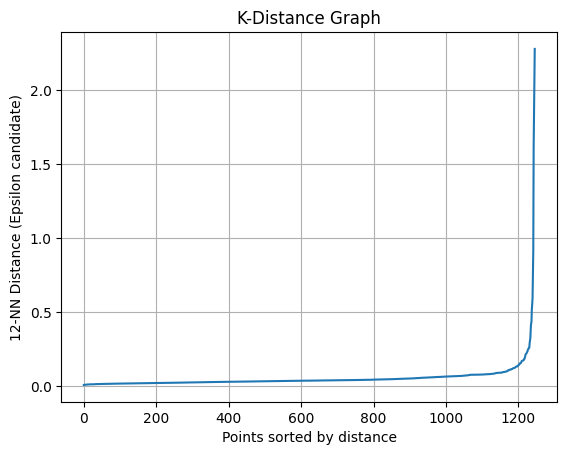

In [7]:
k = 12

# Calculate distance to the k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=k).fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)

# Sort distance to the k-th neighbor (column index k-1)
sorted_distances = np.sort(distances[:, k-1])

# Plot
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN Distance (Epsilon candidate)")
plt.title("K-Distance Graph")
plt.grid(True)
plt.show()

In [8]:
sorted_distances[1200]

np.float64(0.14198799274620494)

In [9]:
dbscan_e = DBSCAN(eps=0.14, min_samples=15, algorithm="auto", metric='euclidean', n_jobs=-1)
dbscan_m = DBSCAN(eps=0.14, min_samples=15, algorithm="auto", metric='manhattan', n_jobs=-1)
dbscan_c = DBSCAN(eps=0.14, min_samples=15, algorithm="auto", metric='cosine', n_jobs=-1)
#dbscan_mh = DBSCAN(eps=0.18, min_samples=15, algorithm="auto", metric='mahalanobis', n_jobs=-1)

density_e = dbscan_e.fit_predict(data_norm)
density_m = dbscan_m.fit_predict(data_norm)
density_c = dbscan_c.fit_predict(data_norm)
#density_mh = dbscan_mh.fit_predict(data_norm)

print(pd.Series(dbscan_e.labels_).value_counts())
print(pd.Series(dbscan_m.labels_).value_counts())
print(pd.Series(dbscan_c.labels_).value_counts())
#print(pd.Series(dbscan_mh.labels_).value_counts())

 1    907
 0    300
-1     39
Name: count, dtype: int64
 2    890
 1    240
-1     89
 0     27
Name: count, dtype: int64
 0    1243
-1       3
Name: count, dtype: int64


In [10]:
results = []
densities = [density_e, density_m, density_c]
labels = [dbscan_e.labels_, dbscan_m.labels_, dbscan_c.labels_]
metrics = ["euclidean", "manhattan", "cosine"]

for i in range((len(densities))):
    # 1. Gürültü Oranı (Noise Ratio) - Çok Önemli!
    noise_ratio = np.sum(labels[i] == -1) / len(labels[i])

    # 2. Silhouette Score (Modelin kendi metriğiyle hesaplanır)
    # Cosine modelini Cosine mesafesiyle değerlendiriyoruz
    score = silhouette_score(data_norm, labels[i], metric=metrics[i])

    results.append({
        'Model': metrics[i],
        'Silhouette Score': score,
        'Clusters Found': len(set(labels[i])) - (1 if -1 in labels[i] else 0),
        'Noise Ratio': f"%{noise_ratio*100:.1f}"
    })

# Sonuçları Tablo Olarak Göster
df_results = pd.DataFrame(results).sort_values(by='Silhouette Score', ascending=False)
print(df_results)

       Model  Silhouette Score  Clusters Found Noise Ratio
2     cosine          0.918034               1        %0.2
0  euclidean          0.747860               2        %3.1
1  manhattan          0.565057               3        %7.1


In [11]:
data["Density"] = density_e

In [12]:
len(density_e)

1246

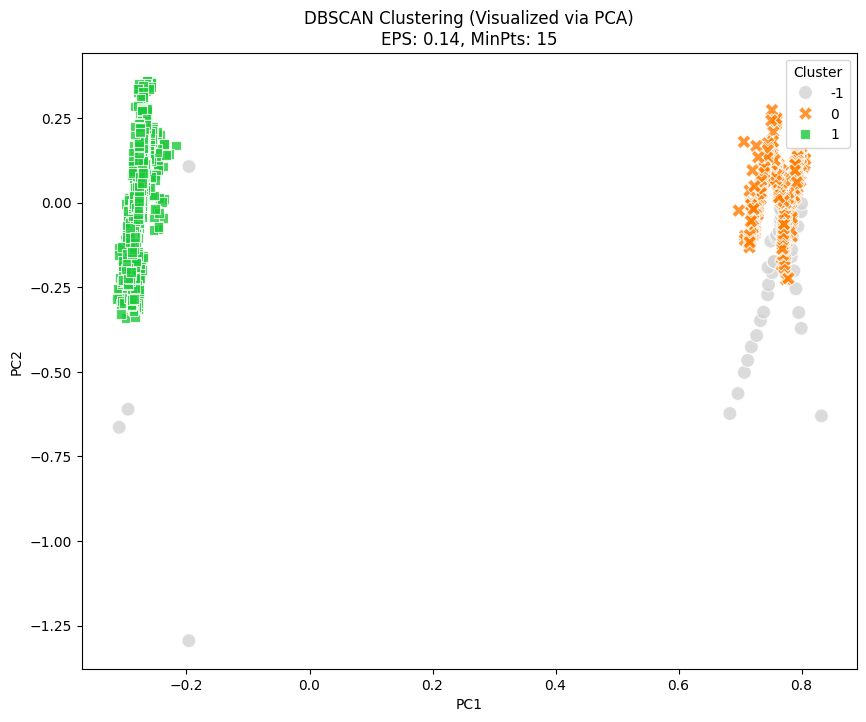

In [13]:
# 1. Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_norm)  # Use your scaled data!

# 2. Create a DataFrame for plotting
df_plot = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = dbscan_e.labels_  # 'labels' comes from dbscan.fit_predict()

# 3. Setup the Plot
plt.figure(figsize=(10, 8))

# Define colors: Use a specific palette, but make sure Noise (-1) is distinct (e.g., Grey)
unique_labels = sorted(df_plot['Cluster'].unique())
palette = sns.color_palette("bright", len(unique_labels))

# If Noise exists, let's map it to a specific dull color (like black or grey)
# and clusters to bright colors
color_dict = dict(zip(unique_labels, palette))
if -1 in color_dict:
    color_dict[-1] = 'lightgrey'  # Make noise less distracting

# 4. Plot
sns.scatterplot(
    data=df_plot, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette=color_dict,
    style='Cluster',      # Different shapes for different clusters
    s=100,                # Dot size
    alpha=0.8,            # Transparency
    edgecolor='w'
)

plt.title(f'DBSCAN Clustering (Visualized via PCA)\nEPS: {dbscan_e.eps}, MinPts: {dbscan_e.min_samples}')
plt.show()

In [14]:
iso_forest = IsolationForest(
    n_estimators=100,         # Yeterli (fazlası gereksiz)
    max_samples=256,          # MAKALENİN SIRRI: "Sub-sampling" başarımı artırır!
    contamination=0.05,       # Verinin %5'i anomali varsayıyoruz (tahmini)
    random_state=42,
    n_jobs=-1
)

# Eğit ve Tahmin Et
iso_forest.fit(data_norm)
labels = iso_forest.predict(data_norm) 
# Çıktı: 1 (Normal), -1 (Anomali)

# SKORLARI AL (Daha Derin Analiz İçin)
# Skor ne kadar düşükse (negatif), o kadar anormaldir.
scores = iso_forest.decision_function(data_norm)

# Sonuçları İncele
n_anomalies = np.sum(labels == -1)
print(f"Tespit edilen anomali sayısı: {n_anomalies}")

# Anomalilerin en 'kötü' olanlarını bul
# Skorları ve indeksleri eşleştirip en düşük skorlu 5'i yazdır
anomaly_indices = np.argsort(scores)[:5]
print("En yüksek anomali skoruna sahip 5 veri noktasının indeksleri:", anomaly_indices)

Tespit edilen anomali sayısı: 63
En yüksek anomali skoruna sahip 5 veri noktasının indeksleri: [1245 1244   22 1243    0]


In [15]:
indexes = []
for i in range(len(data)):
    if data.iloc[i, -1] == -1:
        indexes.append(i)

print(len(indexes))
print(indexes)

39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 47, 48, 203, 1243, 1244, 1245]


In [17]:
data["Isolation"] = labels

In [18]:
# Create masks for anomalies in each model
mask_db = (data["Density"] == -1)
mask_iso = (data["Isolation"] == -1)

# Find rows where BOTH are anomalies (The Intersection)
# This is the "Bad Data" mask
intersection_mask = mask_db & mask_iso

# Filter: Keep rows that are NOT (~) in the intersection
data_clean = data[~intersection_mask].reset_index(drop=True)

print(f"Original shape: {data.shape}")
print(f"Cleaned shape:  {data_clean.shape}")
print(f"Dropped rows:   {data.shape[0] - data_clean.shape[0]}")

Original shape: (1246, 14)
Cleaned shape:  (1208, 14)
Dropped rows:   38


In [19]:
for i in range(len(data.columns)):
    print(i, data.columns[i])

0 Temp (C)
1 Baro (mb)
2 Depth (m)
3 pH
4 ORP (REDOX)
5 DO (% Sat)
6 DO (mg/L)
7 RES (Ohms.cm)
8 SAL (PSU)
9 Turbidity (NTU)
10 CDOM (ug/L)
11 Chlorophyll (ug/L)
12 Density
13 Isolation


In [29]:
X = data.iloc[:, [0,1,2,3,4,7,8,9,10,11]]
y = data.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=430)

In [30]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("=== Training Performance ===")
print(f"R2 Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\n=== Test Performance ===")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

=== Training Performance ===
R2 Score: 0.2439
MSE: 20.7475
RMSE: 4.5549

=== Test Performance ===
R2 Score: 0.2212
MSE: 18.5880
RMSE: 4.3114


In [33]:
# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_scaled)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     31.77
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.47e-53
Time:                        11:44:35   Log-Likelihood:                -2923.4
No. Observations:                 996   AIC:                             5869.
Df Residuals:                     985   BIC:                             5923.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.2577      0.145    938.850      0.0

In [34]:
# Backward Elimination Function
def backward_elimination(X, y, significance_level=0.05):
    """
    Performs backward elimination to remove features with p-value > significance_level
    """
    features = list(X.columns)
    removed_features = []
    
    while True:
        X_with_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_with_const).fit()
        
        # Get p-values (skip the constant at index 0)
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            # Remove feature with highest p-value
            removed_feature = p_values.idxmax()
            features.remove(removed_feature)
            removed_features.append((removed_feature, max_p_value))
            print(f"Removed: {removed_feature} (p-value: {max_p_value:.4f})")
        else:
            break
    
    print(f"\n=== Summary ===")
    print(f"Started with {len(X.columns)} features")
    print(f"Removed {len(removed_features)} features")
    print(f"Remaining {len(features)} features")
    print(f"Final R²: {model.rsquared:.4f}")
    print(f"Final Adjusted R²: {model.rsquared_adj:.4f}")
    
    return features, removed_features, model

# Perform backward elimination
selected_features, removed, final_model = backward_elimination(X_train, y_train, significance_level=0.5)


=== Summary ===
Started with 10 features
Removed 0 features
Remaining 10 features
Final R²: 0.2439
Final Adjusted R²: 0.2362


In [35]:
# Train improved model with selected features only
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

scaler_improved = StandardScaler().fit(X_train_selected)
X_train_selected_scaled = scaler_improved.transform(X_train_selected)
X_test_selected_scaled = scaler_improved.transform(X_test_selected)

model_improved = LinearRegression()
model_improved.fit(X_train_selected_scaled, y_train)

y_pred_train_improved = model_improved.predict(X_train_selected_scaled)
y_pred_test_improved = model_improved.predict(X_test_selected_scaled)

print("=== IMPROVED MODEL (After Backward Elimination) ===\n")
print("Training Performance:")
print(f"R2 Score: {r2_score(y_train, y_pred_train_improved):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train_improved):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_improved)):.4f}")

print("\nTest Performance:")
print(f"R2 Score: {r2_score(y_test, y_pred_test_improved):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test_improved):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_improved)):.4f}")

print(f"\n=== Feature Count ===")
print(f"Original model: {len(X.columns)} features")
print(f"Improved model: {len(selected_features)} features")

=== IMPROVED MODEL (After Backward Elimination) ===

Training Performance:
R2 Score: 0.2439
MSE: 20.7475
RMSE: 4.5549

Test Performance:
R2 Score: 0.2212
MSE: 18.5880
RMSE: 4.3114

=== Feature Count ===
Original model: 10 features
Improved model: 10 features


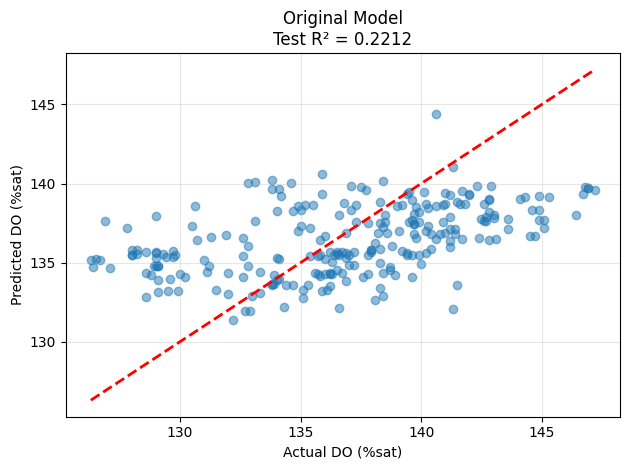

In [38]:
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DO (%sat)')
plt.ylabel('Predicted DO (%sat)')
plt.title(f'Original Model\nTest R² = {r2_score(y_test, y_pred_test):.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Veri Seçimi ve Bölme (Aynı kalıyor)
X = data.iloc[:, [0,1,2,3,4,7,8,9,10,11]]
y = data.iloc[:, 5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=450)

# 2. POLİNOM ÖZELLİKLERİ (Scaling'den ÖNCE!)
# degree=2 genelde en güvenlisidir. 3 ve üzeri overfitting riskini çok artırır.
# include_bias=False diyoruz çünkü LinearRegression() kendi bias'ını zaten ekler.
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 3. ÖLÇEKLENDİRME (Artık genişletilmiş veri setini ölçekliyoruz)
scaler = StandardScaler()

# Poly uygulanmış veri üzerine fit edip dönüştürüyoruz
X_train_final = scaler.fit_transform(X_train_poly)
X_test_final = scaler.transform(X_test_poly)

# 4. MODEL EĞİTİMİ
model = LinearRegression()
model.fit(X_train_final, y_train)

print(f"Orijinal Özellik Sayısı: {X_train.shape[1]}")
print(f"Polinom Sonrası Özellik Sayısı: {X_train_final.shape[1]}")

y_pred_train = model.predict(X_train_final)
y_pred_test = model.predict(X_test_final)

print("=== Training Performance ===")
print(f"R2 Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\n=== Test Performance ===")
print(f"R2 Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

Orijinal Özellik Sayısı: 10
Polinom Sonrası Özellik Sayısı: 65
=== Training Performance ===
R2 Score: 0.8006
MSE: 5.4861
RMSE: 2.3422

=== Test Performance ===
R2 Score: -84623756937353.2031
MSE: 2008389515230166.0000
RMSE: 44815059.0229


In [41]:
# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_final)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     58.39
Date:                Mon, 08 Dec 2025   Prob (F-statistic):          2.07e-280
Time:                        11:50:09   Log-Likelihood:                -2261.0
No. Observations:                 996   AIC:                             4652.
Df Residuals:                     931   BIC:                             4971.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.4472      0.077   1777.496      0.0

In [44]:
# 1. RECOVER FEATURE NAMES
# We need the original column names to generate poly names (e.g., 'Age^2')
input_cols = X.columns
poly_col_names = poly.get_feature_names_out(input_cols)

# 2. CONVERT TO DATAFRAME (Crucial for dropping columns by name)
# We reset index to avoid alignment issues
X_train_df = pd.DataFrame(X_train_final, columns=poly_col_names, index=y_train.index)
X_test_df = pd.DataFrame(X_test_final, columns=poly_col_names, index=y_test.index)

# 3. BACKWARD ELIMINATION LOGIC
significance_level = 0.05

while True:
    # Statsmodels requires explicitly adding a constant (intercept)
    X_with_const = sm.add_constant(X_train_df)
    
    # Fit OLS Model
    ols_model = sm.OLS(y_train, X_with_const).fit()
    
    # Get P-values (exclude 'const' from elimination candidates)
    p_values = ols_model.pvalues.drop('const')
    
    # Find the worst feature
    max_p_value = p_values.max()
    worst_feature = p_values.idxmax()
    
    if max_p_value > significance_level:
        print(f"Dropping: {worst_feature} (p-value: {max_p_value:.4f})")
        # Drop from both Train and Test dataframes to keep them synced
        X_train_df.drop(columns=worst_feature, inplace=True)
        X_test_df.drop(columns=worst_feature, inplace=True)
    else:
        print("\n--- Elimination Complete ---")
        print(f"All remaining features have p-value < {significance_level}")
        break

# 4. FINAL SUMMARY
print(ols_model.summary())

Dropping: ORP (REDOX) Chlorophyll (ug/L) (p-value: 0.9930)
Dropping: ORP (REDOX) SAL (PSU) (p-value: 0.9819)
Dropping: ORP (REDOX) CDOM (ug/L) (p-value: 0.8541)
Dropping: Depth (m)^2 (p-value: 0.8011)
Dropping: Baro (mb) RES (Ohms.cm) (p-value: 0.8149)
Dropping: SAL (PSU)^2 (p-value: 0.5963)
Dropping: RES (Ohms.cm)^2 (p-value: 0.6375)
Dropping: Baro (mb) (p-value: 0.5700)
Dropping: Baro (mb)^2 (p-value: 0.5700)
Dropping: pH Turbidity (NTU) (p-value: 0.4726)
Dropping: Temp (C) Turbidity (NTU) (p-value: 0.6167)
Dropping: ORP (REDOX) Turbidity (NTU) (p-value: 0.6115)
Dropping: Temp (C) Chlorophyll (ug/L) (p-value: 0.4619)
Dropping: Depth (m) SAL (PSU) (p-value: 0.4025)
Dropping: Depth (m) pH (p-value: 0.3451)
Dropping: Depth (m) (p-value: 0.3691)
Dropping: Baro (mb) Depth (m) (p-value: 0.9478)
Dropping: Temp (C) CDOM (ug/L) (p-value: 0.3894)
Dropping: SAL (PSU) Chlorophyll (ug/L) (p-value: 0.3288)
Dropping: SAL (PSU) Turbidity (NTU) (p-value: 0.1834)
Dropping: Temp (C) SAL (PSU) (p-value:

In [47]:
X_train_df_2 = X_train_df.copy()
X_test_df_2 = X_test_df.copy()


columns = ["pH^2", "pH ORP (REDOX)", "pH RES (Ohms.cm)", "pH SAL (PSU)", "pH CDOM (ug/L)", "pH Chlorophyll (ug/L)", 
           "Turbidity (NTU)^2", "Turbidity (NTU) CDOM (ug/L)", "Turbidity (NTU) Chlorophyll (ug/L)", 
           "CDOM (ug/L)^2", "CDOM (ug/L) Chlorophyll (ug/L)", 
           "Baro (mb) pH", "Baro (mb) ORP (REDOX)", "Baro (mb) SAL (PSU)", "Baro (mb) CDOM (ug/L)", "Baro (mb) Chlorophyll (ug/L)",
           "Depth (m) Turbidity (NTU)", "Depth (m) CDOM (ug/L)", "Depth (m) Chlorophyll (ug/L)",
           "Temp (C) Baro (mb)", "Temp (C) Depth (m)", "Temp (C) pH", "RES (Ohms.cm) Turbidity (NTU)", "RES (Ohms.cm) CDOM (ug/L)",
           "SAL (PSU) CDOM (ug/L)"]

X_train_df.drop(columns=columns, inplace=True)
X_test_df.drop(columns=columns, inplace=True)

In [49]:
X_train_df

,Temp (C),ORP (REDOX),RES (Ohms.cm),SAL (PSU),Chlorophyll (ug/L),Temp (C)^2,Temp (C) ORP (REDOX),Temp (C) RES (Ohms.cm),Depth (m) ORP (REDOX),Depth (m) RES (Ohms.cm),ORP (REDOX)^2,ORP (REDOX) RES (Ohms.cm),RES (Ohms.cm) SAL (PSU),RES (Ohms.cm) Chlorophyll (ug/L),Chlorophyll (ug/L)^2
1152,-0.379393,-0.142601,-0.209846,0.182320,-0.537769,-0.377155,-0.197648,-0.277804,-0.047953,-0.116061,-0.149589,-0.234739,-0.069531,-0.609678,-0.170267
1032,-0.379393,0.325784,-0.041868,0.182320,-0.640042,-0.377155,0.188920,-0.116552,0.120370,-0.027926,0.285809,0.163213,0.103821,-0.714270,-0.186172
1110,-0.379393,-0.004841,-0.230843,0.182320,-0.617929,-0.377155,-0.083951,-0.297961,0.001553,-0.127078,-0.022345,-0.168475,-0.091200,-0.700930,-0.182847
791,0.458468,0.518648,-0.062865,0.182320,-0.523949,0.447490,0.517317,0.023607,0.189679,-0.038943,0.467369,0.262577,0.082152,-0.584369,-0.168015
400,-0.379393,-0.004841,0.105113,-0.177265,0.786435,-0.377155,-0.083951,0.024544,0.001553,0.049193,-0.022345,0.071697,-0.117925,0.918977,0.157410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,-0.379393,0.491096,-0.020871,0.182320,-0.603371,-0.377155,0.325355,-0.096395,0.179778,-0.016909,0.441351,0.276806,0.125490,-0.671483,-0.180624
180,-0.379393,-1.382443,0.210099,-0.177265,0.570833,-0.377155,-1.220915,0.125327,-1.295526,-0.936323,-1.264288,-0.681951,-0.011386,0.686497,0.088653
300,-0.379393,-0.748746,0.105113,-0.177265,0.782749,-0.377155,-0.697912,0.024544,-1.088497,-0.986400,-0.701414,-0.373648,-0.117925,0.914780,0.156184
562,-0.379393,0.243127,-0.020871,0.182320,0.688769,-0.377155,0.120702,-0.096395,0.090666,-0.016909,0.208405,0.129219,0.125490,0.791350,0.125521


In [50]:
final_sklearn_model = LinearRegression()
final_sklearn_model.fit(X_train_df, y_train)

# Calculate Adjusted R2 again to see the improvement
print(f"Final Features Count: {X_train_df.shape[1]}")

final_sklearn_model_2 = LinearRegression()
final_sklearn_model_2.fit(X_train_df_2, y_train)

# Calculate Adjusted R2 again to see the improvement
print(f"Final Features Count: {X_train_df_2.shape[1]}")

Final Features Count: 15
Final Features Count: 40


In [51]:
# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_df)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     35.75
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           2.75e-82
Time:                        12:10:25   Log-Likelihood:                -2846.5
No. Observations:                 996   AIC:                             5725.
Df Residuals:                     980   BIC:                             5804.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [52]:
# Add constant for statsmodels
X_train_with_const = sm.add_constant(X_train_df_2)

# Fit OLS model to get p-values
ols_model = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             DO (% Sat)   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     93.72
Date:                Mon, 08 Dec 2025   Prob (F-statistic):          2.94e-299
Time:                        12:10:29   Log-Likelihood:                -2269.8
No. Observations:                 996   AIC:                             4622.
Df Residuals:                     955   BIC:                             4823.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [55]:
y_pred_final_2 = final_sklearn_model_2.predict(X_train_df_2)
y_pred_test_final_2 = final_sklearn_model_2.predict(X_test_df_2)

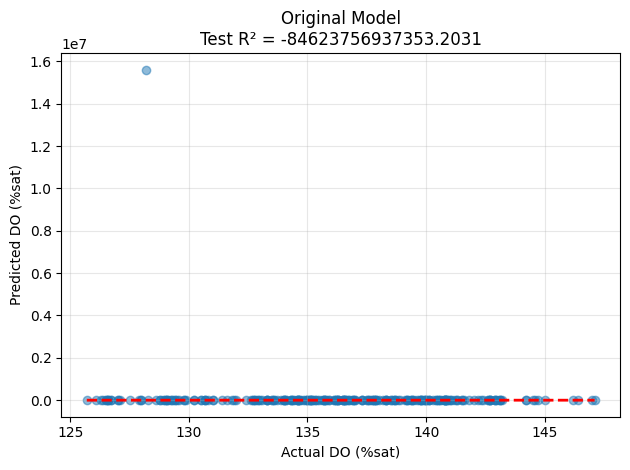

In [56]:
plt.scatter(y_test, y_pred_test_final_2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual DO (%sat)')
plt.ylabel('Predicted DO (%sat)')
plt.title(f'Original Model\nTest R² = {r2_score(y_test, y_pred_test):.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()